In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound as rb
import celmech as cm
import sympy as sp

In [2]:
import sys
sys.path.append("../code")

In [3]:
from three_body_mmr import *

In [4]:
def term_degree(ps_term):
    return np.sum(ps_term.k) + np.sum(ps_term.kbar)

def get_sim(j,Delta1,phi0 = 0):
    Delta2 = -1 * j * Delta1 / (j* Delta1 - (j-1)) 
    P1 = 1
    P2 = j * (1 + Delta1) * P1 /(j-1)
    P3 = j * (1 + Delta2) * P2 /(j-1)
    Nplanet = 3
    mpl = 3e-5
    sim = rb.Simulation()
    sim.units=("year","AU","Msun")
    sim.add(m=1)
    for i in range(Nplanet):
        #sim.add(m=mpl, P = Pratio**i, e = 0.01, l= 0,pomega = 0)
        sim.add(m=mpl, P = [P1,P2,P3][i], e = 0.0, l= [0,0,(np.pi + phi0)/ j][i],pomega = 0)
    sim.move_to_com()
    pvars = cm.Poincare.from_Simulation(sim)
    pham = cm.PoincareHamiltonian(pvars)
    
    jvec = np.array((j-1,1-2*j,j))
    mmr_terms = list_resonance_terms(j,1,min_order=1,max_order=1,inclinations=False)
    lst = pair_mmr_lists(1,2,3,jvec,-1,mmr_terms,mmr_terms,0)
    full_series = get_three_body_mmr_terms(pham,lst)
    # Function that determines the degree of a Poisson series term in powers
    # of e and inc
    cond = lambda term: np.linalg.matrix_rank((term.q,(j-1,1-2*j,j)))==1 and np.sum(term.p)==0 and term_degree(term)==0
    select_terms = [term for term in full_series.terms if cond(term)]
    assert len(select_terms)==2
    eps = np.abs(select_terms[0].C +  select_terms[1].C)
    omega = pham.flow_func(*pham.state.values)[:pham.N_dof:3].reshape(-1)
    domega = np.diag(pham.jacobian_func(*pham.state.values)[:pham.N_dof:3,pham.N_dof::3])
    A = jvec**2 @ domega
    dP = 2*np.sqrt(np.abs(eps / A))
    j_d_ln_omega = jvec * (domega/omega)
    xlow = P1/P2 * (1 + (j_d_ln_omega[1] - j_d_ln_omega[0]) * dP)
    xhi  = P1/P2 * (1 - (j_d_ln_omega[1] - j_d_ln_omega[0]) * dP) 
    
    ylow = P2/P3 * (1 + (j_d_ln_omega[2] - j_d_ln_omega[1]) * dP)
    yhi  = P2/P3 * (1 - (j_d_ln_omega[2] - j_d_ln_omega[1]) * dP) 
    
    return np.array([[xlow,xhi],[ylow,yhi]]),sim,pham

In [84]:
jhi = 5
jlo = jhi-1
Delta1 = 0.01
_,_,pham = get_sim(jhi,Delta1,2.9)

In [85]:
from celmech.lie_transformations import FirstOrderGeneratingFunction

In [86]:
chi = FirstOrderGeneratingFunction(pham.state)

chi.add_MMR_terms(jhi,1,indexIn=1,indexOut=2)
chi.add_MMR_terms(jlo,1,indexIn=1,indexOut=2)
chi.add_zeroth_order_term(indexIn=1,indexOut=2)

chi.add_MMR_terms(jhi,1,indexIn=2,indexOut=3)
chi.add_MMR_terms(jlo,1,indexIn=2,indexOut=3)
chi.add_zeroth_order_term(indexIn=2,indexOut=3)


chi.mean_to_osculating()


In [87]:
sim_osc = chi.state.to_Simulation()
sim_osc.integrator='whfast'
cm.nbody_simulation_utilities.set_time_step(sim_osc,1/20)

In [88]:
sim_osc.automateSimulationArchive("3br.sa",step=500,deletefile=True)
Tfin = sim_osc.dt * 20 * 30_000
sim_osc.integrate(Tfin)

In [89]:
sa = rb.SimulationArchive('3br.sa')
N = len(sa)
nb_t = np.zeros(N)
nb_periods = np.zeros((N,3))
nb_e = np.zeros((N,3))
nb_angle = np.zeros(N)
for i,sim in enumerate(sa):
#     if i>=N:
#         break
    pv = cm.Poincare.from_Simulation(sim)
    mean_state_values = chi.osculating_to_mean_state_vector(pv.values)
    pv.values = mean_state_values
    nb_periods[i] = [p.P for p in pv.particles[1:]]
    nb_e[i] = [p.e for p in pv.particles[1:]]
    nb_t[i] = sim.t
    nb_angle[i] = np.array((jlo,1-2*jhi,jhi)) @ [p.l for p in pv.particles[1:]]

(0.0, 6.283185307179586)

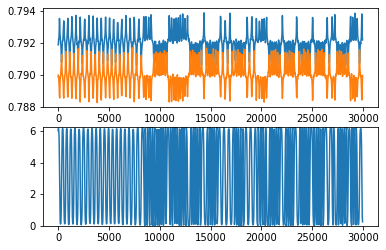

In [90]:
fig,ax = plt.subplots(2,1)
ax[0].plot(nb_t,nb_periods[:,0]/nb_periods[:,1])
ax[0].plot(nb_t,nb_periods[:,1]/nb_periods[:,2])

nb_angle = np.mod(nb_angle,2*np.pi)
ax[1].plot(nb_t,nb_angle)
ax[1].set_ylim(0,2*np.pi)

In [91]:
Npts = 20

PR_inner,PR_outer = np.zeros((2,Npts,2))
for i,delta in enumerate(np.geomspace(0.003,0.1,Npts)):
    arr,*_=get_sim(jhi,delta)
    PR_inner[i],PR_outer[i]=arr



PR_inner2,PR_outer2 = np.zeros((2,Npts,2))
for i,delta in enumerate(np.geomspace(0.003,0.1,Npts)):
    arr,*_=get_sim(jlo,-1*delta)
    PR_inner2[i],PR_outer2[i]=arr


(0.76, 0.8200000000000001)

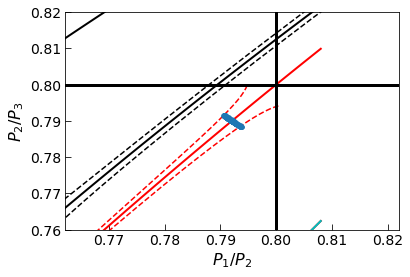

In [92]:

pratio_in = np.linspace((jlo-1)/jlo * 0.99,(jhi-1)/jhi * 1.01)
jlist = (jlo,jhi)
# Combinations of 1st order MMRs
for i,j_in in enumerate(jlist):
    for j_out in jlist:
        # d/dt (theta_out - theta_in) = 0
        pratio_out = (j_in  + (1-j_in)/pratio_in - (1-j_out)) / j_out
        l,=plt.plot(pratio_in[pratio_out>0],pratio_out[pratio_out>0],lw=2,color='kr'[i])



pratio_out = 2  - 1/pratio_in
l,=plt.plot(pratio_in[pratio_out>0],pratio_out[pratio_out>0],lw=2,color='c')

plt.plot(PR_inner[:,0],PR_outer[:,0],'r--')
plt.plot(PR_inner[:,1],PR_outer[:,1],'r--')

plt.plot(PR_inner2[:,0],PR_outer2[:,0],'k--')
plt.plot(PR_inner2[:,1],PR_outer2[:,1],'k--')

        
plt.xlim((jlo-1)/jlo * 0.99 ,(jhi-1)/jhi * 1.01)
plt.ylim((jlo-1)/jlo * 0.99 ,(jhi-1)/jhi * 1.01)

plt.xlabel("$P_1/P_2$",fontsize=16)
plt.ylabel("$P_2/P_3$",fontsize=16)
plt.tick_params(labelsize=14,direction='in',size=6)
for j in jlist:
    w = 2 if int(2*j % 2) else 3
    plt.axvline((j-1)/j,lw=w,color='k')
    plt.axhline((j-1)/j,lw=w,color='k')

plt.plot(nb_periods[:,0]/nb_periods[:,1],nb_periods[:,1]/nb_periods[:,2],'.')



P = [p.P for p in pham.particles[1:]]



PR_x = (jhi-1)/jhi/(1+Delta1)
Delta2 = -1 * jhi * Delta1 / (jhi* Delta1 - (jhi-1)) 
PR_y = (jhi-1)/jhi/(1+Delta2)

plt.xlim(PR_x-0.03 ,PR_x+0.03)
plt.ylim(PR_y-0.03 ,PR_y+0.03)


In [93]:
5/j

1.0

In [65]:
result = cm.nbody_simulation_utilities.get_simarchive_integration_results("3br.sa")

/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:1987: FutureWarning: sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead
  warnings.warn( "sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead", FutureWarning)


In [68]:
from scipy.ndimage import uniform_filter1d

In [ ]:
uniform_filter1d()

In [71]:
len(nb_e)

1201

(0.0, 0.01)

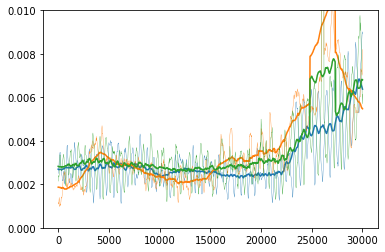

In [79]:
for i in range(3):
    l,=plt.plot(nb_t,uniform_filter1d(nb_e[:,i],10),lw=0.3)
    l,=plt.plot(nb_t,uniform_filter1d(nb_e[:,i],100),color=l.get_color())
plt.ylim(0,0.01)